# Boosting 算法

严格来讲Boosting不是一种算法，而是一族算法，该族算法有一个类似的框架：
- 根据当前的数据训练出一个弱模型。
- 根据该弱模型的表现调整数据样本的权重，具体调整方法如下：
   
   1.让该弱模型做错的样本在后续训练中获得更多的关注；
   
   2.让该弱模型做对的样本在后续训练中获得较少的关注。

- 最后再根据该弱模型的表现决定改模型的"话语权"，即投票表决时的"可信度"。表现越好的就越有话语权。

Boosting算法处理步骤：

第一步：初始化所有权重为$w=\frac{1}{n}$,其中$n$是数据集总的实例数。

$\quad (1)$当$t<T(T是模型的数量)$时：

$\quad (2)$创建模型并获得数据集中所有数据点$x_n$的假设$h_t(x_n)$

$\quad (3)$用以下公式计算训练集中所有数据点$x_n$的误差$\varepsilon$：
$${\varepsilon_t =\frac{\sum_{n=1}^{N}w_{n}^{(t)}*I(y_n \not =h_t(x_n))}{\sum_{n=1}^{N}w_{n}^{(t)}}}$$
$\quad$如果$I(y_n \not = h_t(x_n))$为$True$则返回1，否则返回0.

$\quad$ 计算系数$\alpha$:
$${\alpha_t=\log\left( \frac{1-\varepsilon_{t}}{\varepsilon_{t}}\right)}$$

第二步：使用以下公式更新下一个(t+1)模型中$N$个训练样本的权重：

$$w_{n}^{(t+1)}=w_{n}^{t}*\exp\left(\alpha_{t}*I(y_n \not = h_t(x_n))\right)$$

第三步：经过$T$次迭代后，得到最终分类器：

$$f(x)=\operatorname{sign}\left(\sum_{t}^{T} \alpha_{t}*h_t(x_n)\right)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import style
style.use('fivethirtyeight')
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
import scipy.stats as sps
# Load in the data and define the column labels
dataset = pd.read_csv('../data/mushrooms.csv',header=None)
dataset = dataset.sample(frac=1)
dataset.columns = ['target','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing',
             'gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring',
             'stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population',
             'habitat']
# 由于sklearn DecisionTreeClassifier仅采用数值，因此将字符串中的要素值编码为整数
for label in dataset.columns:
    dataset[label] = LabelEncoder().fit(dataset[label]).transform(dataset[label])
    
    
Tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=1)
X = dataset.drop('target',axis=1)
Y = dataset['target'].where(dataset['target']==1,-1)
predictions = np.mean(cross_validate(Tree_model,X,Y,cv=100)['test_score'])
print('The accuracy is: ',predictions*100,'%')

The accuracy is:  73.0727281302264 %


In [2]:
class Boosting:
    def __init__(self,dataset,T,test_dataset):
        self.dataset = dataset
        self.T = T
        self.test_dataset = test_dataset
        self.alphas = None
        self.models = None
        self.accuracy = []
        self.predictions = None
    
    def fit(self):
        # Set the descriptive features and the target feature
        X = self.dataset.drop(['target'],axis=1)
        Y = self.dataset['target'].where(self.dataset['target']==1,-1)
        # 初始化每个样本的权重 wi = 1/N ，并创建一个计算评估的DataFrame
        Evaluation = pd.DataFrame(Y.copy())
        Evaluation['weights'] = 1/len(self.dataset) # 初始化权值为 w = 1/N
        
        
        alphas = [] 
        models = []
        
        for t in range(self.T):
            #训练决策树 Stump(s)
            Tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=1) #
            
            """
            在加权数据集上训练决策树分类器，其中权重是取决于先前决策树训练的结果，
            为此，这里使用上述创建的评估DataFrame的权重和fit方法的sample_weights参数，
            该参数序列如果为None,则表示样本的权重相等，如果不是None，则表示样本的权重不均等。
            """
            model = Tree_model.fit(X,Y,sample_weight=np.array(Evaluation['weights'])) 
            
            # 将单个弱分类器附加到列表中，该列表稍后用于进行加权决策
            models.append(model)
            predictions = model.predict(X)
            score = model.score(X,Y)
            # 将值添加到评估 DataFrame中
            Evaluation['predictions'] = predictions
            Evaluation['evaluation'] = np.where(Evaluation['predictions'] == Evaluation['target'],1,0)
            Evaluation['misclassified'] = np.where(Evaluation['predictions'] != Evaluation['target'],1,0)
            # 计算误分类率和准确性
            accuracy = sum(Evaluation['evaluation'])/len(Evaluation['evaluation'])
            misclassification = sum(Evaluation['misclassified'])/len(Evaluation['misclassified'])
            # 计算错误率
            err = np.sum(Evaluation['weights']*Evaluation['misclassified'])/np.sum(Evaluation['weights'])
 
   
            # 计算alpha值
            alpha = np.log((1-err)/err)
            alphas.append(alpha)
            # 更新权重 wi --> 这些更新后的权重值在sample_weight参数中用于训练写一个决策树分类器
            Evaluation['weights'] *= np.exp(alpha*Evaluation['misclassified'])
            
        
        self.alphas = alphas
        self.models = models
            
    def predict(self):
        X_test = self.test_dataset.drop(['target'],axis=1).reindex(range(len(self.test_dataset)))
        Y_test = self.test_dataset['target'].reindex(range(len(self.test_dataset))).where(self.dataset['target']==1,-1)
    
        
        # 对于self.model列表中的每个模型，进行预测
        accuracy = []
        predictions = []
        
        for alpha,model in zip(self.alphas,self.models):
            prediction = alpha*model.predict(X_test) # 对列表中的单个决策树分类器模型使用预测方法
            predictions.append(prediction)
            self.accuracy.append(np.sum(np.sign(np.sum(np.array(predictions),axis=0))==Y_test.values)/len(predictions[0]))
            
        self.predictions = np.sign(np.sum(np.array(predictions),axis=0))
   
        

With a number of  50 base models we receive an accuracy of  98.67076923076922 %


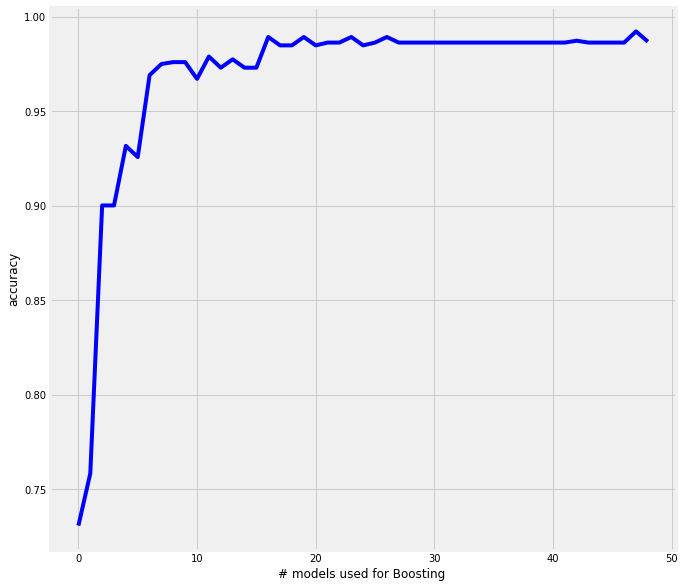

In [3]:
#根据使用的模型数量绘制模型精度
number_of_base_learners = 50
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
for i in range(number_of_base_learners):
    model = Boosting(dataset,i,dataset)
    model.fit()
    model.predict()
ax0.plot(range(len(model.accuracy)),model.accuracy,'-b')
ax0.set_xlabel('# models used for Boosting ')
ax0.set_ylabel('accuracy')
print('With a number of ',number_of_base_learners,'base models we receive an accuracy of ',model.accuracy[-1]*100,'%')    
                 
plt.show()    

**上述案例均已通过**

----
参考资料：  
《统计学习方法》  

整理制作：深度学习学研社

<div>
<table align="left" border="1" bordercolor="#000000">
    <div>
    <tr>
        <td>
            微信公众号：ID: AI_class_vip<br>
            <img src="../image/gongzhonghao.jpg" width="150" height="150" align="left"/>    
        </td>
    </tr>
    </div>
    <div>
    <tr>
        <td>
        知识星球：机器学习交流学习圈：<br>
    <img src="../image/dlzhishixingqiu.jpg" width="150" height="150" align="left"/>  
        </td>
    </tr>
        </div>
    <div>
     <tr>
        <td>
        配置环境：python 3.4+  
        </td>
    </tr>
        </div>
</table>
</div>
